#########################################################################
 MoRed - GeM Laboratory
 ECOLE CENTRALE DE NANTES
#########################################################################

In [ ]:
import os
import numpy as np
from scipy import sparse
import itertools
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from pytictoc import TicToc

In [ ]:
from library import FEM_mat_1D, FEM_mat_2D

### DATA ENTRY

 Similar problem as Lab1_1 but this time the thermal conductivity is a nonlinear function of the temperature T

 FIXED POINT TOLERANCE

In [ ]:
fp_tol = 1e-7

### LOAD FINITE ELEMENT MESH, TIME DISCRETIZATION

  1 subtracted from connectivity tables for 0-based indexing of python

In [ ]:
connectAll = np.loadtxt('Mesh_M2/connectAll.txt', delimiter=',', dtype=int)-1
connectDown = np.loadtxt('Mesh_M2/connectDown.txt', delimiter=',', dtype=int)-1
connectHole = np.loadtxt('Mesh_M2/connectHole.txt', delimiter=',', dtype=int)-1
connectLeft = np.loadtxt('Mesh_M2/connectLeft.txt', delimiter=',', dtype=int)-1
connectRight = np.loadtxt('Mesh_M2/connectRight.txt', delimiter=',', dtype=int)-1
connectUp = np.loadtxt('Mesh_M2/connectUp.txt', delimiter=',', dtype=int)-1
nodesAll = np.loadtxt('Mesh_M2/nodesAll.txt', delimiter=',')

In [ ]:
X = nodesAll[:, 0]
Y = nodesAll[:, 1]
numOfNodes = nodesAll.shape[0]
reducedBasis = np.loadtxt('Reduced_Basis/reducedBasis.txt', delimiter=',')
M_r = np.loadtxt('Reduced_Basis/M_r.txt', delimiter=',')
K_r = []
i = 0
while os.path.exists(f'Reduced_Basis/K_r_{i}.txt'):
    K_r.append(np.loadtxt(f'Reduced_Basis/K_r_{i}.txt', delimiter=','))
    i += 1
Int_t = np.loadtxt('Reduced_Basis/Int_t.txt', delimiter=',')
Int_c = np.loadtxt('Reduced_Basis/Int_c.txt', delimiter=',')
density = np.loadtxt('Reduced_Basis/density.txt', delimiter=',')
k0 = np.loadtxt('Reduced_Basis/k0.txt', delimiter=',')
specificHeat = np.loadtxt('Reduced_Basis/specificHeat.txt', delimiter=',')
condfun = lambda T: k0*(1+0.5*((T+1)**5-1))

 TIME INTERVAL, TIME INCREMENT,

In [ ]:
timeSpan = 1
timeInc = 0.01
time = np.linspace(0,timeSpan,int(timeSpan/timeInc)+1)
numOfFrames = time.size

### BOUNDARY CONDITIONS & HEAT SOURCES

 INITIAL CONDITION

In [ ]:
solution = np.zeros([reducedBasis.shape[1], numOfFrames])

 NEWMANN BC

In [ ]:
nodesNeu = np.unique(connectHole.reshape(-1))
ampliNeu = np.sin((2*np.pi*time)/timeSpan)
ampliNeu[ampliNeu<0] = 0
valuesNeu = 1*np.outer(np.ones(nodesNeu.size), ampliNeu)

 HEAT SOURCE

In [ ]:
ampliSource = np.sin(2*np.pi/timeSpan*(time-timeSpan/2))
ampliSource[ampliSource<0] = 0
valuesSource = 3*np.outer(np.ones(numOfNodes), ampliSource)

### SOLVE USING REDUCED EQUATIONS

 finite element operators

In [ ]:
opMass = FEM_mat_2D(nodesAll,connectAll,0,0,0,0)
opMassNeuBc = FEM_mat_1D(nodesAll,connectHole,0,0)

 right-hand side

In [ ]:
auxSp = np.array(list(itertools.product(np.arange(0,numOfFrames),nodesNeu))) ## itertools.product returns Cartesian product of two sets
auxNeumann = sparse.lil_array((numOfNodes,numOfFrames))
for r, c, val in zip(auxSp[:,1], auxSp[:,0], valuesNeu.reshape(-1, order='F')):
    auxNeumann[r, c] = val

In [ ]:
rhsNeumannFree = opMassNeuBc @ auxNeumann
rhsSourceFree = opMass @ valuesSource

 sum contributions and project on reduced basis

In [ ]:
rhsTotalFree = reducedBasis.T @ (rhsNeumannFree + rhsSourceFree)
## Auxiliary variable used to hold Temperature fields
auxT = solution[:,0]
## TIME INTEGRATION LOOP (first order single step)
t = TicToc()
t.tic()
for i in range(1,numOfFrames):
    it = 0
    err = 1
    rhs = density*specificHeat*M_r @ solution[:,i-1] + timeInc*rhsTotalFree[:,i]
    while (err > fp_tol) & (it<100):
        it = it +1
        ## evaluate the conductivity field
        T_eim = Int_t @ solution[:,i-1] # to complete # temperature at eim points at i-1 step
        cond_eim = condfun(T_eim)       # to complete # conductivity at eim points at i-1 step
        beta_cond = np.linalg.solve(Int_c, cond_eim)  # to complete # coefficients of matrices K_r's
        ## assemble reduced LHS operator
        A = density*specificHeat*M_r
        for j in range(len(K_r)):
            A += timeInc*  beta_cond[j] * K_r[j] # to complete # hint: use operators K_r's
        ## solve system
        solution[:,i] = np.linalg.solve(A,rhs)
        err = np.linalg.norm(solution[:,i]-auxT)/np.linalg.norm(solution[:,i])
        auxT=solution[:,i]
    print(f"Time step {i} of {numOfFrames} , error is : {err:0.2e}, iter {it}")

Time step 1 of 101 , error is : 0.00e+00, iter 2
Time step 2 of 101 , error is : 0.00e+00, iter 2
Time step 3 of 101 , error is : 0.00e+00, iter 2
Time step 4 of 101 , error is : 0.00e+00, iter 2
Time step 5 of 101 , error is : 0.00e+00, iter 2
Time step 6 of 101 , error is : 0.00e+00, iter 2
Time step 7 of 101 , error is : 0.00e+00, iter 2
Time step 8 of 101 , error is : 0.00e+00, iter 2
Time step 9 of 101 , error is : 0.00e+00, iter 2
Time step 10 of 101 , error is : 0.00e+00, iter 2
Time step 11 of 101 , error is : 0.00e+00, iter 2
Time step 12 of 101 , error is : 0.00e+00, iter 2
Time step 13 of 101 , error is : 0.00e+00, iter 2
Time step 14 of 101 , error is : 0.00e+00, iter 2
Time step 15 of 101 , error is : 0.00e+00, iter 2
Time step 16 of 101 , error is : 0.00e+00, iter 2
Time step 17 of 101 , error is : 0.00e+00, iter 2
Time step 18 of 101 , error is : 0.00e+00, iter 2
Time step 19 of 101 , error is : 0.00e+00, iter 2
Time step 20 of 101 , error is : 0.00e+00, iter 2
Time step

In [ ]:
execTime = t.tocvalue()
print(f"Time integration loop executed in {execTime:0.4f} sec\n")

Time integration loop executed in 0.0222 sec



COMPUTE SOLUTION USING REDUCED BASIS AND REDUCED COEFFICIENTS

In [ ]:
reducedSolution = solution
rom_solution = reducedBasis @ solution

### POST PROCESS

SAVE SOLUTION

In [ ]:
os.makedirs('ROM_Solution/plots/', exist_ok=True)
np.savetxt('ROM_Solution/rom_solution.txt', rom_solution, delimiter=',')
np.savetxt('ROM_Solution/reducedSolution.txt', reducedSolution, delimiter=',')

 PLOT RESULTS

Text(0, 0.5, 'source term amplitude')

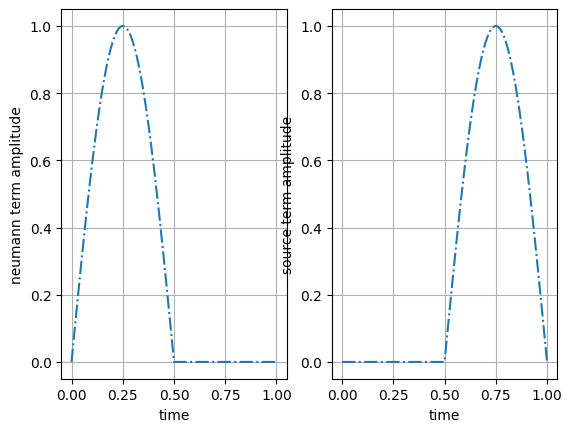

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(time, ampliNeu, linestyle='dashdot')
ax.grid()
ax.set_xlabel('time')
ax.set_ylabel('neumann term amplitude')
ax = fig.add_subplot(122)
ax.plot(time, ampliSource, linestyle='dashdot')
ax.grid()
ax.set_xlabel('time')
ax.set_ylabel('source term amplitude')

 PLOT TIME SOLUTION (Dynamic plots may not work on notebooks/deepnote. In that case, visualize the solution using the saved (png) figures)

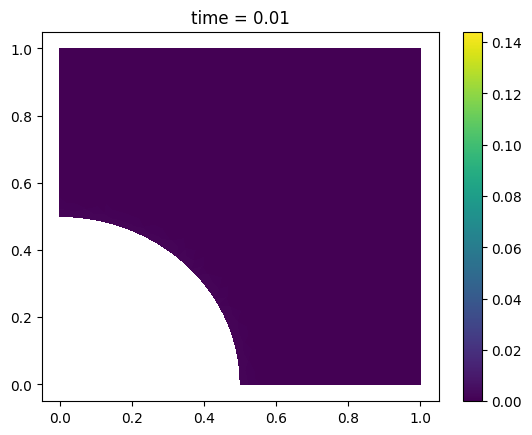

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
solution2plot = rom_solution[:,0]
vmin = 0.9*rom_solution.min()
vmax = 1.1*rom_solution.max()
if connectAll.shape[1]==4:
    f1 = ax.pcolormesh([X, Y], solution2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'time = {time[0]:0.2f}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, numOfFrames):
        solution2plot = rom_solution[:,i]
        f1.set_array(solution2plot)
        ax.set_title(f'time = {time[i]:0.2f}')
        if ((i%int(numOfFrames/10))==0) | (i==numOfFrames-1):
            fig.savefig(f'ROM_Solution/plots/SolAtTime={time[i]:0.2f}.png')
        plt.pause(5/numOfFrames)
elif connectAll.shape[1]==3:
    Tri = Triangulation(X, Y, triangles=connectAll)
    f1 = ax.tripcolor(Tri, solution2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'time = {time[0]:0.2f}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, numOfFrames):
        solution2plot = rom_solution[:,i]
        # f1.set_array(solution2plot)
        f1 = ax.tripcolor(Tri, solution2plot, vmin=vmin, vmax=vmax)
        ax.set_title(f'time = {time[i]:0.2f}')
        if ((i%int(numOfFrames/10))==0) | (i==numOfFrames-1):
            fig.savefig(f'ROM_Solution/plots/SolAtTime={time[i]:0.2f}.png')
        plt.pause(5/numOfFrames)
plt.show(0)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6e4ec535-1a42-4f7f-9f57-76554989f508' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>